# Cycle3 NAO comparison plot

We compare the NAO teleconnection patterns between ERA5 and the nextGEMS simulations.
Data have been obtained with the CLI available in the `cli` folder of the diagnostic.

Setup files for the CLI used to produce these data are available in the repository, in the `cli` folder.

In [1]:
import xarray as xr

from teleconnections.plots import maps_plot

In [2]:
# Load the data
path = '/home/b/b382289/aqua_telec_output/NetCDF/NAO/'

models = ['IFS', 'IFS', 'ICON', 'ERA5']
exps = ['tco1279-orca025-cycle3', 'tco2559-ng5-cycle3', 'ngc3028', 'era5']

## Regression plots

We compare the regression plots obtained from ERA5 and nextGEMS simulations.
Notice that we don't compare here the index values, but they're available as they were produced by the CLI.

In [3]:
# Regressions
regs = []

regs.append(xr.open_dataarray(path + 'teleconnections_IFS_tco1279-orca025-cycle3_lra-r100-monthly_NAO_regression.nc'))
regs.append(xr.open_dataarray(path + 'teleconnections_IFS_tco2559-ng5-cycle3_lra-r100-monthly_NAO_regression.nc'))
regs.append(xr.open_dataarray(path + 'teleconnections_ICON_ngc3028_lra-r100-monthly_NAO_regression.nc'))
regs.append(xr.open_dataarray(path + 'teleconnections_ERA5_era5_monthly_NAO_regression.nc'))

# Custom titles so that different time periods can be shown

titles = ['IFS tco1279 (2020-01, 2024-12)',
          'IFS tco2559 (2020-01, 2024-12)',
          'ICON 3028 (2020-01, 2025-07)',
          'ERA5 (1940-01, 2022-12)']

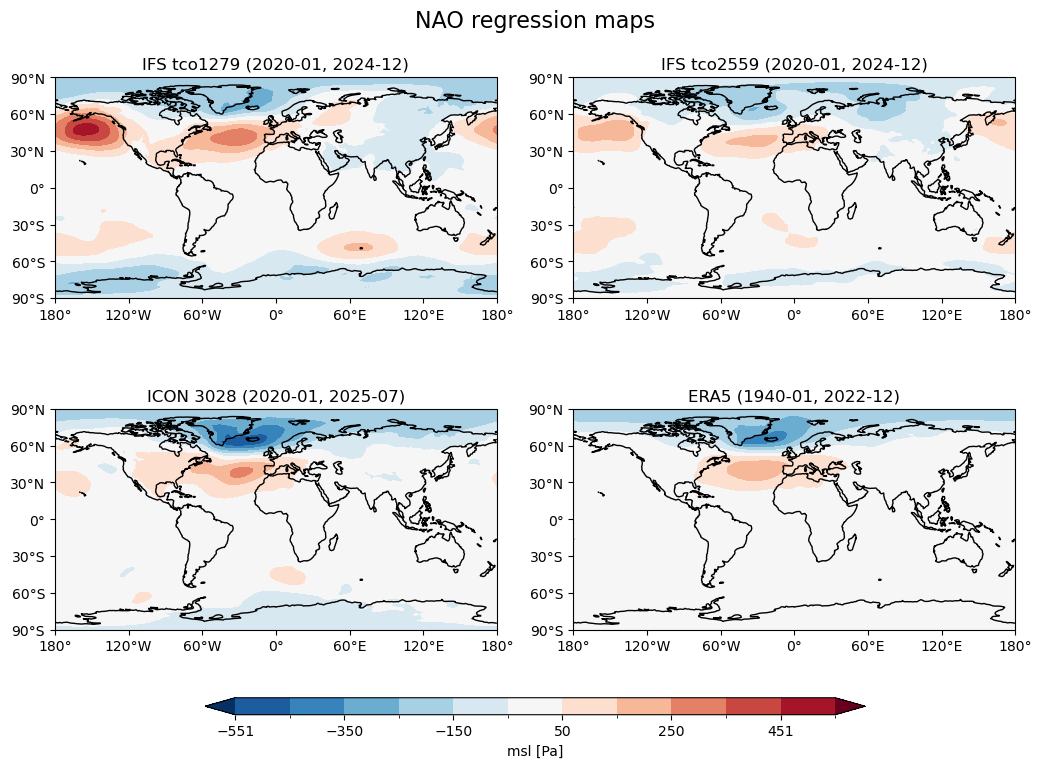

In [4]:
maps_plot(maps=regs, models=models, exps=exps, title='NAO regression maps', titles=titles, cbar_label='msl [Pa]', nlevels=12)

## Correlation plots

We compare the correlation plots obtained from ERA5 and nextGEMS simulations, same as the regression plots.

In [5]:
# Correlations
cors = []

cors.append(xr.open_dataarray(path + 'teleconnections_IFS_tco1279-orca025-cycle3_lra-r100-monthly_NAO_correlation.nc'))
cors.append(xr.open_dataarray(path + 'teleconnections_IFS_tco2559-ng5-cycle3_lra-r100-monthly_NAO_correlation.nc'))
cors.append(xr.open_dataarray(path + 'teleconnections_ICON_ngc3028_lra-r100-monthly_NAO_correlation.nc'))
cors.append(xr.open_dataarray(path + 'teleconnections_ERA5_era5_monthly_NAO_correlation.nc'))

titles = ['IFS tco1279 (2020-01, 2024-12)',
          'IFS tco2559 (2020-01, 2024-12)',
          'ICON 3028 (2020-01, 2025-07)',
          'ERA5 (1940-01, 2022-12)']

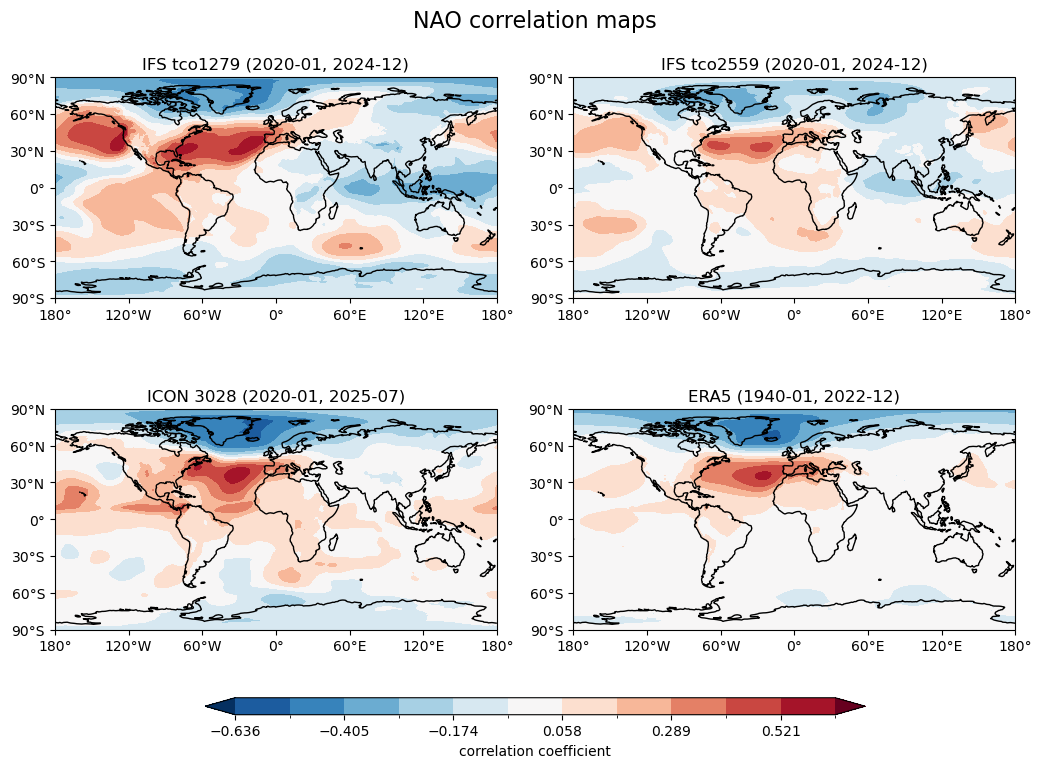

In [6]:
maps_plot(maps=cors, models=models, exps=exps, title='NAO correlation maps', titles=titles, cbar_label='correlation coefficient', nlevels=12)

## ERA5 comparison

Finally we plot the maps obtained from the subtraction of the ERA5 regression/correlation maps from the nextGEMS regression/correlation maps.

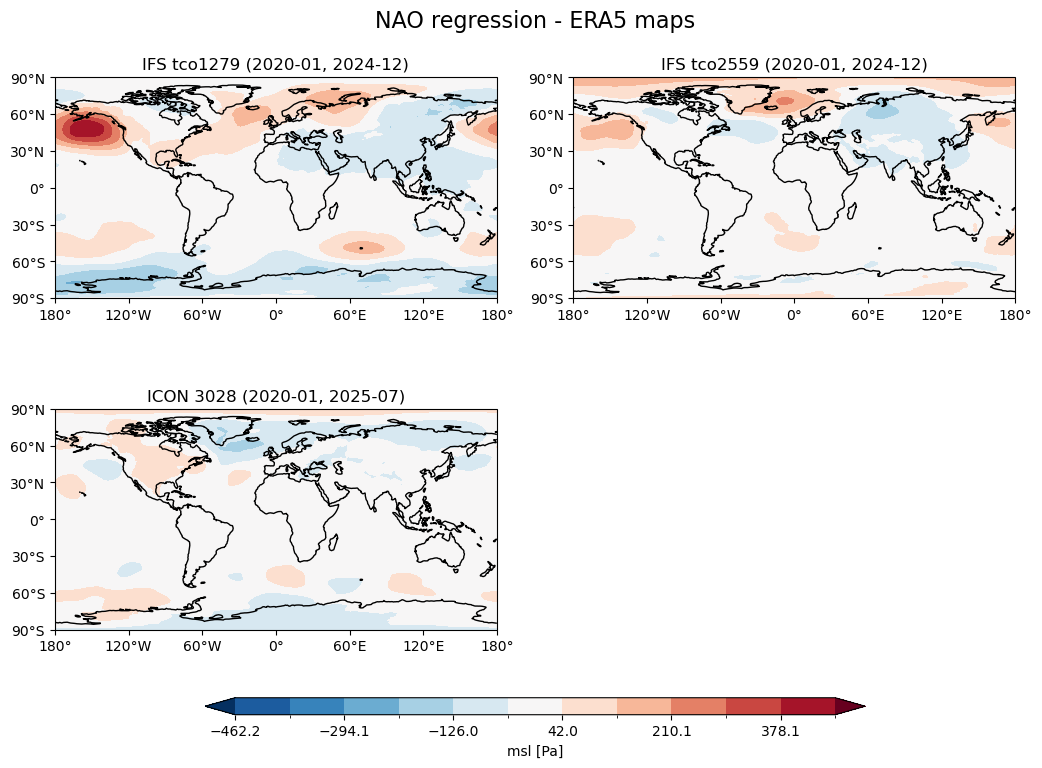

In [7]:
# Difference between experiments and ERA5 for regression
diffs_reg = []

for i in range(len(models)):
    diffs_reg.append(regs[i] - regs[-1])

titles = ['IFS tco1279 (2020-01, 2024-12)',
          'IFS tco2559 (2020-01, 2024-12)',
          'ICON 3028 (2020-01, 2025-07)',
          'ERA5 (1940-01, 2022-12)']

diffs_reg.pop(-1)

maps_plot(maps=diffs_reg, models=models, exps=exps, title='NAO regression - ERA5 maps', titles=titles, cbar_label='msl [Pa]', nlevels=12)

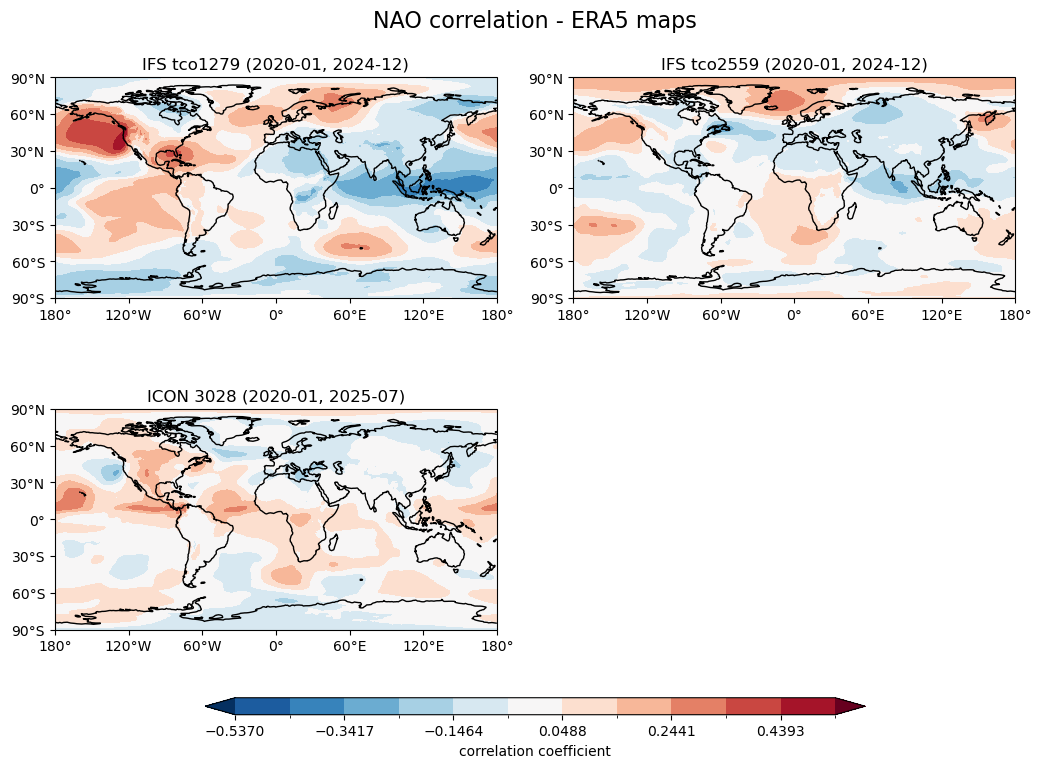

In [8]:
# Difference between experiments and ERA5 for correlation
diffs_cor = []

for i in range(len(models)):
    diffs_cor.append(cors[i] - cors[-1])

titles = ['IFS tco1279 (2020-01, 2024-12)',
          'IFS tco2559 (2020-01, 2024-12)',
          'ICON 3028 (2020-01, 2025-07)',
          'ERA5 (1940-01, 2022-12)']

diffs_cor.pop(-1)

maps_plot(maps=diffs_cor, models=models, exps=exps, title='NAO correlation - ERA5 maps', titles=titles, cbar_label='correlation coefficient', nlevels=12)

In [13]:
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import numpy as np

from aqua.logger import log_configure

from teleconnections.plots import minmax_maps, plot_box

def maps_diffs_plot(maps=None, diffs=None, models=None, exps=None,
              titles=None, save=False, **kwargs):
    """
    Plot maps (regression, correlation, etc.)
    A list of xarray.DataArray objects is expected
    and a map is plotted for each of them

    Args:
        maps (list):        list of xarray.DataArray objects
        diffs (list):       list of xarray.DataArray objects
        models (list):      list of models
        exps (list):        list of experiments
        titles (list, opt): list of titles for each map
                            overrides models and exps standard titles
        save (bool, opt):   save the figure
        **kwargs:           additional arguments
    """
    loglevel = kwargs.get('loglevel', 'WARNING')
    logger = log_configure(loglevel, 'Multiple maps')

    if maps is None:
        raise ValueError('Nothing to plot')

    if models is None and titles is None:
        logger.warning('No titles provided')
    if exps is None and titles is None:
        logger.warning('No titles provided')

    # Generate the figure
    nrows, ncols = plot_box(len(maps))
    figsize = kwargs.get('figsize', (11, 8.5))

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=figsize)
    axs = axs.flatten()

    # Evaluate min and max values for the common colorbar
    vmin, vmax = minmax_maps(maps)
    logger.debug('Min value for the colorbar: {}'.format(vmin))
    logger.debug('Max value for the colorbar: {}'.format(vmax))

    # Drop unused axes
    for i in range(len(axs)):
        if i >= len(maps):
            axs[i].axis('off')
            logger.debug('Dropping unused axes {}'.format(i))

    # Set the number of levels for the colorbar
    nlevels = kwargs.get('nlevels', 11)

    # Plot the maps
    for i in range(len(maps)):
        try:
            logger.info('Plotting model {} experiment {}'.format(models[i],
                                                                 exps[i]))
        except TypeError:
            logger.info('Plotting map {}'.format(i))

        # Contour plot
        cs = maps[i].plot.contourf(ax=axs[i], transform=ccrs.PlateCarree(),
                                   cmap='RdBu_r', levels=nlevels,
                                   add_colorbar=False, add_labels=False,
                                   extend='both', vmin=vmin, vmax=vmax)

        # Line contours with diffs
        if diffs is not None:
            try:
                diffs[i].plot.contour(ax=axs[i], transform=ccrs.PlateCarree(),
                                    colors='k', levels=10, linewidths=0.5)
            except IndexError:
                logger.warning('No diff for map {}'.format(i))
        # Title
        if titles is not None:
            axs[i].set_title(titles[i])
        else:  # Use models and exps
            try:
                axs[i].set_title('{} {}'.format(models[i], exps[i]))
            except TypeError:
                logger.warning('No title for map {}'.format(i))

        # Coastlines
        axs[i].coastlines()

        # Longitude labels
        axs[i].set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                        wspace=0.1, hspace=0.5)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])

    # Add the colorbar
    fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')

    # Colorbar label
    cbar_label = kwargs.get('cbar_label', '')
    if cbar_label is not None:
        cbar_ax.set_xlabel(cbar_label)

    # Add a super title
    title = kwargs.get('title')
    if title is not None:
        fig.suptitle(title, fontsize=16)

    # Save the figure
    if save is True:
        outputdir = kwargs.get('outputdir', '.')
        filename = kwargs.get('filename', 'maps.png')
        logger.info('Saving figure to {}/{}'.format(outputdir, filename))
        fig.savefig('{}/{}'.format(outputdir, filename), format='pdf',
                    dpi=300, bbox_inches='tight')

2023-07-11 17:14:18 :: Multiple maps :: WARNING  -> No diff for map 3


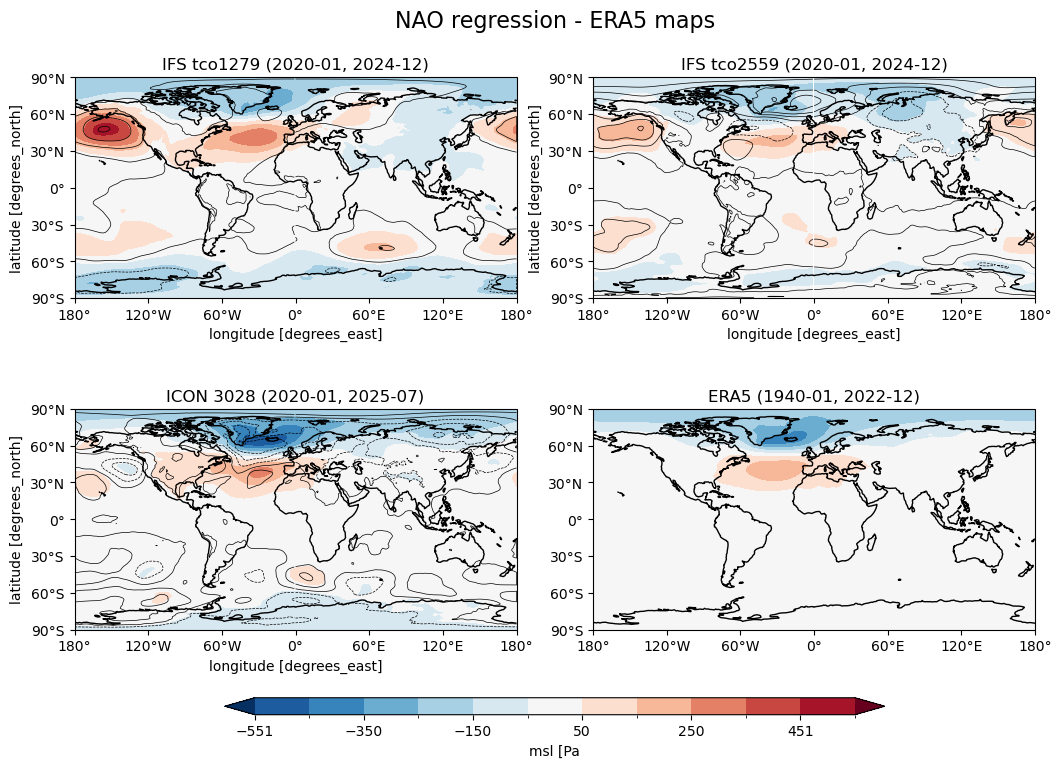

In [15]:
maps_diffs_plot(maps=regs, diffs=diffs_reg, models=models, exps=exps, title='NAO regression - ERA5 maps', titles=titles, cbar_label='msl [Pa]', nlevels=12)